# Run 1, Direct Contact Area Analysis

In [1]:
# %matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import pims
import scipy.interpolate as intp
import scipy.optimize as opt

import vfetools as vt
import twodpg

In [2]:
plt.style.use('../matplotlibrc')
pltt = sbn.color_palette([c['color'] for c in plt.rcParams['axes.prop_cycle']])
pltt

[(0.0, 0.18823529411764706, 0.43529411764705883),
 (0.0, 0.6235294117647059, 0.5058823529411764),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (1.0, 0.43137254901960786, 0.22745098039215686),
 (0.5176470588235295, 0.0, 0.803921568627451),
 (0.0, 0.5529411764705883, 0.9764705882352941),
 (0.0, 0.5843137254901961, 0.011764705882352941),
 (0.0, 0.7607843137254902, 0.9764705882352941),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (1.0, 0.7647058823529411, 0.23137254901960785)]

## Global Constants

- `NBANDS`: Number of vertical bands used.
- `FRATE`: Frame rate of the video; frames per second.
- `IMRES`: Spacial image (video) resolution; mm per pixel.

In [3]:
NBANDS = 10
FRATE = 60000 / 1001
IMRES = 0.07677

Key frames and times:

- `FSTART`, `TSTART`: First contact of sample with water.
- `FREF`, `TREF`: Reference frame from which the sample outline was created.

In [4]:
FOFF = 575
FSTART = 634 - FOFF
FSUBM = 648 - FOFF
TSTART = FSTART / FRATE
FREF = 1200 - FOFF
TREF = FREF / FRATE

- `YSURF`: Vertical coordinate of initial sample contact.

In [5]:
YSURF = 339

## Get Data

### Image Sequence \& Polygons

In [6]:
seq = pims.ImageSequence('../data/2016-08-11_run1_frames/*.jpg')
len(seq)

1798

In [7]:
pols = vt.FilmPolygons('../data/2016-08-11_run1_polygons_prepped.json', frame_offset=0)
len(pols)

166

### Time Line

In [8]:
pols.frames

array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134,
       136, 138, 140, 141, 149, 157, 165, 173, 181, 197, 209, 221])

Time array for analyzed frames, starting at the sample's first contact

In [9]:
MSTART = np.where(pols.frames == FSUBM)[0][0]
MSTART, pols.frames[MSTART]

(13, 73)

In [10]:
t = (pols.frames[MSTART:-1] - FSTART) / FRATE
t

array([0.23356667, 0.25025   , 0.26693333, 0.28361667, 0.3003    ,
       0.31698333, 0.33366667, 0.35035   , 0.36703333, 0.38371667,
       0.4004    , 0.41708333, 0.43376667, 0.45045   , 0.46713333,
       0.48381667, 0.5005    , 0.51718333, 0.53386667, 0.55055   ,
       0.56723333, 0.58391667, 0.6006    , 0.61728333, 0.63396667,
       0.65065   , 0.66733333, 0.68401667, 0.7007    , 0.71738333,
       0.73406667, 0.75075   , 0.76743333, 0.78411667, 0.8008    ,
       0.81748333, 0.83416667, 0.85085   , 0.86753333, 0.88421667,
       0.9009    , 0.91758333, 0.95095   , 0.98431667, 1.01768333,
       1.05105   , 1.08441667, 1.11778333, 1.15115   , 1.18451667,
       1.21788333, 1.25125   , 1.28461667, 1.31798333, 1.35135   ,
       1.36803333, 1.5015    , 1.63496667, 1.76843333, 1.9019    ,
       2.03536667, 2.3023    , 2.5025    ])

### Vertices of Each Pixel

- `iidx`: $(N, 2)$ shaped array of the location of the upper left pixel corners. Basically a list of each $(x,y)$-index of a frame.
- `icoords`: $(N, 2)$ shaped array of each pixel's center. This adds 0.5 to $x$ and $y$ values of each element in `iidx`.

In [11]:
iidx = twodpg.image_index(1920, 1080)
icoords = iidx + .5

## Sample Motion

- `yb`: $y$ coordinate of the sample bottom.

In [12]:
tb = (pols.frames[:-1] - FSTART) / FRATE
yb = np.array([pols[fnum, 'ref'][0][:, 1].max() for fnum in pols.frames[:-1]])
yb

array([341., 391., 430., 466., 514., 549., 588., 631., 667., 697., 727.,
       742., 759., 785., 797., 814., 827., 845., 849., 860., 870., 879.,
       885., 885., 894., 899., 901., 904., 903., 898., 902., 898., 899.,
       901., 897., 891., 896., 888., 886., 889., 892., 897., 897., 901.,
       900., 905., 910., 910., 914., 908., 909., 901., 896., 890., 885.,
       874., 867., 861., 866., 866., 879., 883., 891., 898., 905., 916.,
       920., 920., 922., 912., 898., 885., 885., 922., 916., 885.])

- `ybott()`: Callable (cubic) spline interpolation of the sample bottom.

In [13]:
ybott = intp.UnivariateSpline(tb, yb, k=3)

- `tp`: time values for plotting 'continuous' curves.

In [14]:
tp = np.linspace(t[0], t[-1], 500, True)

## Helper Functions

### `vt.bands()`

Returns (`NBANDS` + 1) y-coordinates of boundaries matching a polygon assumed to be the sample outline
of one frame.

In [15]:
vt.bands?

Signature: vt.bands(pol, nbands: int = 10) -> numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]]
Docstring:
Returns `nbands` + 1 y-coordinates of boundaries matching a polygon
assumed to be the sample outline.

Parameters
----------
pol : ndarray
    Sample outline.
nbands : int
    Number of ybands to return.
File:      /synced/other/Projects/vfe/anl/vfetools.py
Type:      function


### `areas()`

1. Check each pixel location, if it lies inside, outside or on the edge of the reference polygon. For each y-band Count the number of pixels in that band.
2. For every of the direct contact polygons, check whether or not each pixel location lies inside the polygon.
3. For every vertical band count the pixels which of the pixels lying inside each polygon also have $y$-coordinates that belong to the band.

***Returns:*** Count of pixels in each y-band:
`'ref'`: inside the reference polygon, `'direct'`: inside the direct contact polygons  
Each pixel location corresponds to an area of one square pixel.

In [16]:
def areas(ref, directs):
    return vt.direct_area(ref, directs, icoords, YSURF, NBANDS)

### `show()`

In [17]:
def show(fnum, rpol=None, rcent=None, xlim=None, ylim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.imshow(seq[fnum], zorder=0)
    if rpol is not None:
        ax.add_artist(plt.Polygon(
            rpol, closed=False,
            fill=False, ec=pltt[3], lw=1, zorder=1
        ))
    if rcent is not None:
        ax.plot(*rcent, 'x', color=pltt[3], ms=8)
    opt = {}
    opt['xlim'] = (rcent[0] - 300, rcent[0] + 300)
    opt['ylim'] = (rcent[1] + 300, rcent[1] - 300)
    if xlim is not None:
        opt['xlim'] = xlim
    if ylim is not None:
        opt['ylim'] = ylim
    ax.set(**opt)
    fig.tight_layout()
    return fig, ax

### `show_markup()`

Make a comparison plot, left showing a 'blank' part of a video frame, right that same frame with added direct contact polygons
and sample outline.

In [18]:
def show_markup(fnum, ybands=False, sharex=True, sharey=True, figax=None):
    ref, = pols[fnum,'ref']
    centr = twodpg.centroid(ref)
    directs = list(pols[fnum, 'direct'])
    if figax is not None:
        fig, (ax1, ax2) = figax
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=sharex, sharey=sharey)
    ax1.imshow(seq[fnum])
    show(fnum, rpol=ref, rcent=centr, ax=ax2)
    ax2.set(ylim=(930, 430))
    ax2.hlines(YSURF, *ax2.get_xlim(), color='white', lw=.5, ls='dashed', zorder=.5)
    for direct in directs:
        ax2.add_artist(plt.Polygon(direct, closed=True, color=pltt[5], lw=.5, zorder=.7))
    fig.set_size_inches(9, 4)
    fig.subplots_adjust(top=.95, bottom=.1, wspace=0.1)
    if ybands:
        ybands = vt.bands(ref)
        ax2.hlines(ybands, *ax2.get_xlim(), color='white', ls='dotted', lw=.5, zorder=.6)
        ax2.set_yticks(ybands)
        ax2.set_yticklabels([r'%2.1f' % n for n in (ybands[0] - ybands) * IMRES])
    return fig, (ax1, ax2)

## Video Analysis

### Side by Side Plots to Check Markup

Frame([[[140, 127, 119],
        [138, 125, 117],
        [135, 122, 114],
        ...,
        [ 64,  62,  67],
        [ 63,  61,  66],
        [ 63,  61,  66]],

       [[143, 130, 122],
        [140, 127, 119],
        [137, 124, 116],
        ...,
        [ 64,  62,  67],
        [ 64,  62,  67],
        [ 64,  62,  67]],

       [[144, 131, 123],
        [143, 130, 122],
        [140, 127, 119],
        ...,
        [ 65,  63,  68],
        [ 65,  63,  68],
        [ 65,  63,  68]],

       ...,

       [[ 85,  83,  84],
        [ 87,  85,  86],
        [ 88,  86,  87],
        ...,
        [ 76,  75,  71],
        [ 76,  75,  71],
        [ 77,  76,  72]],

       [[ 87,  85,  86],
        [ 88,  86,  87],
        [ 89,  87,  88],
        ...,
        [ 76,  75,  71],
        [ 76,  75,  71],
        [ 77,  76,  72]],

       [[ 87,  85,  86],
        [ 89,  87,  88],
        [ 90,  88,  89],
        ...,
        [ 77,  76,  72],
        [ 78,  77,  73],
        [ 78,  77,  73]]], dtype=uint8)
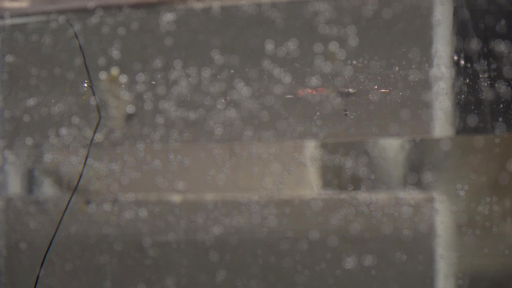

In [19]:
seq[635 - FOFF] #[:250, 200:780]

In [20]:
b = vt.bands(pols[715 - FOFF, 'ref'][0])

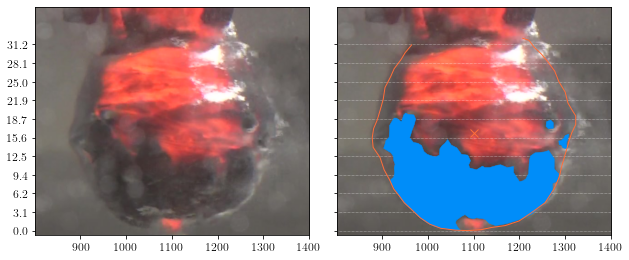

In [21]:
fig, (ax1, ax2) = show_markup(715 - FOFF, True)

### Collect Results for All Frames

In [22]:
pols.frames

array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134,
       136, 138, 140, 141, 149, 157, 165, 173, 181, 197, 209, 221])

In [23]:
area = {
    fnum: areas(pols[fnum, 'ref'][0], pols[fnum, 'direct'])
    for fnum in pols.frames[MSTART:-1]
}

In [24]:
d_areas = np.nan * np.zeros((len(pols.frames[MSTART:-1]), NBANDS))
ref_areas = np.nan * np.zeros((len(pols.frames[MSTART:-1]), NBANDS))
for i in range(NBANDS):
    d_areas[:, i] = np.array([area[fnum]['direct'][i] for fnum in pols.frames[MSTART:-1]])
    ref_areas[:, i] = np.array([area[fnum]['ref'][i] for fnum in pols.frames[MSTART:-1]])

In [25]:
rel_areas = np.empty_like(ref_areas)
idx = ~np.isclose(ref_areas, 0)
rel_areas[idx] = d_areas[idx] / ref_areas[idx]
rel_areas[rel_areas > 1.] = 1

In [26]:
yb_centers = vt.bands(pols[668 - FOFF, 'ref'][0])[:-1]
yb_centers = IMRES * (yb_centers[0] - yb_centers)
Δymm = (yb_centers[-1] - yb_centers[0]) / (len(yb_centers) - 1)
Δymm

3.124539

In [27]:
yb_centers += .5 * Δymm
yb_centers

array([ 1.5622695,  4.6868085,  7.8113475, 10.9358865, 14.0604255,
       17.1849645, 20.3095035, 23.4340425, 26.5585815, 29.6831205])

In [28]:
ybands = vt.bands(pols[715 - FOFF, 'ref'][0])
ybands

array([920. , 879.3, 838.6, 797.9, 757.2, 716.5, 675.8, 635.1, 594.4,
       553.7, 513. ])

Index of frame 714 in the time and area arrays.

In [29]:
np.where(pols.frames[MSTART:-1] == 715 - FOFF)

(array([54]),)

### View Example Frame

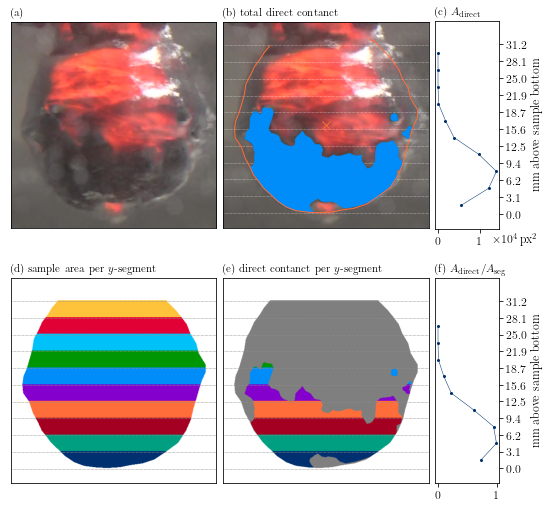

In [30]:
ref = pols[715 - FOFF, 'ref'][0]
directs = pols[715 - FOFF, 'direct']
frame = seq[715 - FOFF].copy()
frame[:, :] = np.array([255, 255, 255])
sample = twodpg.points_in_polygon(icoords, ref) > 0
sample = np.logical_and(sample, icoords[:, 1] >= ybands[-1])
smplcr = iidx[sample]
frame[smplcr[:, 1], smplcr[:, 0]] = np.array([.5, .5, .5]) * 255
ybands = vt.bands(ref)
for i, clr in enumerate(pltt[:10]):
    sel = np.logical_and(sample, icoords[:, 1] <= ybands[i])
    sel = np.logical_and(sel, icoords[:, 1] > ybands[i + 1])
    sel = iidx[sel]
    frame[sel[:, 1], sel[:, 0]] = np.array(clr) * 255
frame4 = seq[714].copy()
frame4[:, :] = np.array([255, 255, 255])
frame4[smplcr[:, 1], smplcr[:, 0]] = np.array([.5, .5, .5]) * 255
for i, clr in enumerate(pltt[:10]):
    sel = np.logical_and(sample, icoords[:, 1] <= ybands[i])
    sel = np.logical_and(sel, icoords[:, 1] > ybands[i + 1])
    for direct in directs:
        ici = twodpg.points_in_polygon(icoords, direct) > 0
        sel1 = np.logical_and(sel, ici)
        sel2 = iidx[sel1]
        frame4[sel2[:, 1], sel2[:, 0]] = np.array(clr) * 255
centr = np.asarray(twodpg.centroid(ref), dtype=int)

fig, axd = plt.subplot_mosaic(
    '''
    aaabbbc
    dddeeef
    ''')
ax1, ax2, ax3, ax4 = axd['a'], axd['b'], axd['d'], axd['e']
ax5, ax6 = axd['c'], axd['f']
show_markup(715 - FOFF, True, False, False, figax=(fig, (ax1, ax2)))
ax1.set(
    xlim=(centr[0] - 250, centr[0] + 250),
    ylim=(centr[1] + 250, centr[1] - 250),
    xticks=[], yticks=[]
)
ax1.set_title(r'(a)', loc='left', fontsize=11)
ax2.set(
    xlim=(centr[0] - 250, centr[0] + 250),
    ylim=(centr[1] + 250, centr[1] - 250),
    xticks=[], yticks=[],
)
ax2.set_title(r'(b) total direct contanct', loc='left', fontsize=11)
ax3.imshow(frame)
ax3.set(
    xlim=(centr[0] - 250, centr[0] + 250),
    ylim=(centr[1] + 250, centr[1] - 250),
    xticks=[], yticks=[]
)
ax3.hlines(ybands, *ax3.get_xlim(), color='black', lw=.5, ls='dotted', zorder=.4)
ax3.hlines(ybands, *ax3.get_xlim(), color='white', lw=.5, ls='dotted', zorder=.5)
ax3.set_title(r'(d) sample area per $y$-segment', loc='left', fontsize=11)
ax4.imshow(frame4)
ax4.set(
    xlim=(centr[0] - 250, centr[0] + 250),
    ylim=(centr[1] + 250, centr[1] - 250),
    xticks=[], yticks=[]
)
ax4.hlines(ybands, *ax4.get_xlim(), color='black', lw=.5, ls='dotted', zorder=.4)
ax4.hlines(ybands, *ax4.get_xlim(), color='white', lw=.5, ls='dotted', zorder=.5)
ax4.set_title(r'(e) direct contanct per $y$-segment', loc='left', fontsize=11)
ax5.plot(d_areas[53] / 1e4, ybands[:-1] - .5 * (ybands[0] - ybands[1]),
         lw=.5, ls='solid', marker='.', ms=4)
ax5.set(
    # aspect=.007,
    ylim=ax2.get_ylim(),
    ylabel=r'mm above sample bottom',
    yticks=ybands,
    xlabel=r'$\times10^{4}\,\mathrm{px^2}$'
)
ax5.set_title(r'(c) $A_\text{direct}$', loc='left', fontsize=11)
ax5.set_yticklabels([r'%2.1f' % n for n in (ybands[0] - ybands) * IMRES])
ax5.xaxis.set_label_coords(1.25, -.025, transform=ax5.transAxes)
ax5.yaxis.set_ticks_position('right')
ax5.yaxis.set_label_position('right')
ax6.plot(rel_areas[53], ybands[:-1] - .5 * (ybands[0] - ybands[1]),
         lw=.5, ls='solid', marker='.', ms=4)
ax6.set(
    aspect=.007,
    ylim=ax4.get_ylim(),
    ylabel=r'mm above sample bottom',
    yticks=ybands,
    # xlim=(0, 1)
)
ax6.set_title(r'(f) $A_\text{direct}/A_\text{seg}$', loc='left', fontsize=11)
ax6.set_yticklabels([r'%2.1f' % n for n in (ybands[0] - ybands) * IMRES])
ax6.yaxis.set_ticks_position('right')
ax6.yaxis.set_label_position('right')
fig.set_size_inches(7.5, 7.0)
fig.subplots_adjust(right=.915, bottom=.05, top=.97, left=.01, hspace=.23, wspace=.1)

### Plot Direct Contact Area Time Dependency

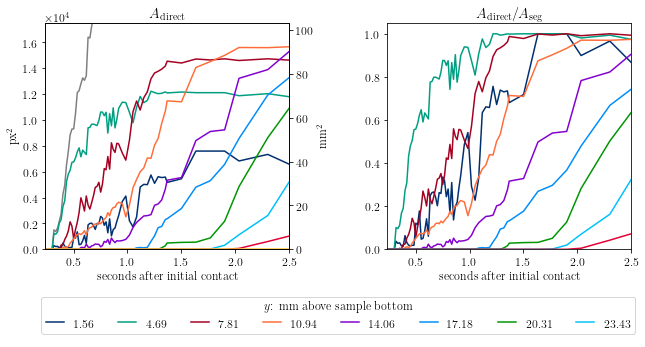

In [31]:
fig, axs = plt.subplot_mosaic('AB\nAB\nAB\nCC', figsize=(9, 5))
ax1, ax2, ax3 = axs['A'], axs['B'], axs['C']

ax1.plot(t, d_areas.sum(axis=1), color='gray')
ax1.set(
    xlabel='seconds after initial contact',
    ylabel=r'$\mathrm{px^2}$',
    xlim=t[[0, -1]],
    ylim=(0, 1.75e4),
    title=r'$A_\text{direct}$'
)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-1, 3))
ax1a = ax1.twinx()
ax1a.set(
    ylim=(0, 1.75e4 * IMRES ** 2),
    ylabel=r'$\mathrm{mm^2}$'
)
ax2.set(
    xlabel=r'seconds after initial contact',
    title=r'$A_\text{direct} / A_\text{seg}$',
    xlim=t[[0, -1]],
    ylim=(0, 1.05)
)
for i, ybc in enumerate(yb_centers):
    ax1.plot(t, d_areas[:, i])
    ax2.plot(t, rel_areas[:, i])
    if i < 8:
        ax3.plot([], [], label=f'{ybc:.2f}')
ax3.legend(
    loc='lower center', ncol=8, handlelength=1.5,
    title=r'$y\text{: mm above sample bottom}$')
for v in ax3.spines.values():
    v.set_visible(False)
ax3.set(xticks=[], yticks=[])
fig.subplots_adjust(left=.075, right=.98, bottom=.0, wspace=.4, hspace=1)

### Y-Dependency of First Contact Time

Tracking some reference point on the sample, for example it's bottom, $y_\text{b}$, allows to determine
the time of first contact of each $y$-band, which can be used to say something about  film lifetime.

If $y_i$ is the vertical coordinate of the center of the $i$-th band above the sample bottom, it relates to
$y_\text{b}$ byt the offset

$$
y_i(t) = y_\text{b}(t) - \bigl(1/2 + i\bigr)\,\frac{y_\text{b}-y_\text{t}}{N_\text{bands}}
= y_\text{b}(t) - \bigl(1/2 + i\bigr)\,\Delta y
\quad,\quad
i = 0, 1, \dots, 9
\quad.
$$ 

$\Delta y$ is the sample's height and does not depend on the (current) sample position.

Since the sample bottom $y_\text{b}(t)$ is not given as formula, inversion of the dependency must be done numerically.

In [32]:
def ybtm(time):
    time, isarr = np.asarray(time), True
    if time.ndim < 1:
        time, isarr = np.array([time]), False
    ret = np.empty_like(time)
    idx = time > t[13]
    if np.any(idx):
        ret[idx] = ybott(t[13])
    idx = ~idx
    if np.any(idx):
        ret[idx] = ybott(time[idx])
    return ret if isarr else ret[0]

In [33]:
t[13]

0.45045

In [34]:
ylm = ybott(t[13])
ylm

array(902.68136353)

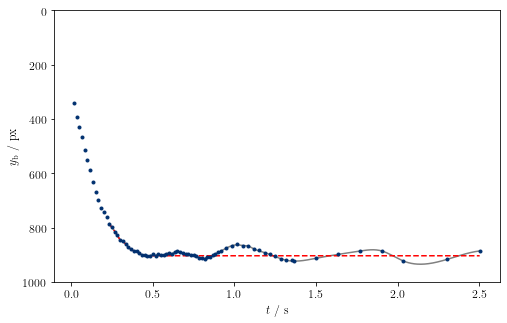

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(tb, yb, '.', zorder=1)
ax.plot(tp, ybott(tp), color='gray', ls='solid', zorder=0)
ax.plot(tp, ybtm(tp), color='red', ls='dashed', zorder=0.5)
ax.set(
    xlabel=r'$t\ /\ \mathrm{s}$',
    ylabel=r'$y_\text{b}\ /\ \mathrm{px}$',
    ylim=(1000, 0)
);

In [36]:
ybands = np.array([vt.bands(pols[frame, 'ref'][0]) for frame in pols.frames])

In [37]:
Δy = (ybands[0, 0] - ybands[0, -1]) / NBANDS
Δy

40.7

In [38]:
YSURF

339

In [39]:
t[13]

0.45045

### Time Deltas for Sample Motion Compensation

In [40]:
tf = []
for i in range(NBANDS):
    ymea = (.5 + i) * Δy
    if ymea >= ylm - YSURF:
        tf.append(t[13])
    else:
        def func(x):
            return ybtm(x) - YSURF - ymea
        fa, fb = func(0), func(2.5)
        if fa * fb > 0:
            print(f"skipping {i}")
            continue
        tf.append(opt.brentq(func, a=0., b=.6))
tf = np.asarray(tf)
tf

array([0.0219951 , 0.03688242, 0.05556816, 0.07189481, 0.08728432,
       0.10614957, 0.12277122, 0.139424  , 0.15973073, 0.18321712])

### Plot Time Dependent Areas Against Sample Motion Compensated Time Line

In [41]:
rref_areas = ref_areas.copy()
rref_areas[np.isnan(ref_areas)] = 0.

In [42]:
d_areas.sum(axis=1) / rref_areas.sum(axis=1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01130702, 0.01035723, 0.01239249, 0.01643286, 0.02066922,
       0.03213454, 0.03719254, 0.04918552, 0.05704012, 0.06668124,
       0.07005073, 0.07023164, 0.0791265 , 0.09139838, 0.09246124,
       0.09643377, 0.09988618, 0.09852933, 0.10111487, 0.12363845,
       0.1231937 , 0.13014375, 0.13468917, 0.13808881, 0.14112663,
       0.14761686, 0.14885309, 0.15460459, 0.16100436, 0.16480352,
       0.1584339 , 0.16603976, 0.17142189, 0.18144745, 0.16807502,
       0.18529937, 0.19534   , 0.20153625, 0.19322936, 0.19405854,
       0.21562479, 0.24523409, 0.27032059, 0.27935113, 0.2903114 ,
       0.31262391, 0.32681044, 0.34046178, 0.35426388, 0.37574721,
       0.38799647, 0.39704208, 0.469211  , 0.48373674, 0.51046653,
       0.57843677, 0.65853567, 0.71179925])

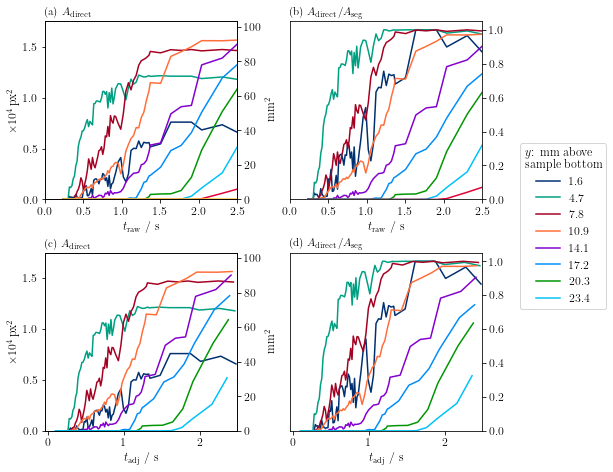

In [43]:
fig, axs = plt.subplot_mosaic(
    '''
    AABBL
    CCDDL
    ''', figsize=(8.5, 6.5))
ax1, ax2, ax3, ax4 = axs['A'], axs['B'], axs['C'], axs['D']
legax = axs['L']

ax1.set(
    xlabel=r'$t_\text{raw}\ /\ \mathrm{s}$',
    ylabel=r'$\times10^4\,\mathrm{px^2}$',
    xlim=(0, 2.5), ylim=(0, 1.75), yticks=(0, .5, 1, 1.5)
)
ax1.set_title(r'(a) $A_\text{direct}$', loc='left', fontsize=11)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-1, 3))
ax1a = ax1.twinx()
ax1a.set(ylim=(0, 1.75e4 * IMRES ** 2), ylabel=r'$\mathrm{mm^2}$')
ax2.set(
    xlabel=r'$t_\text{raw}\ /\ \mathrm{s}$',
    ylim=(0, 1.05), xlim=(0, 2.5)
)
ax2.set_title(r'(b) $A_\text{direct} / A_\text{seg}$', loc='left', fontsize=11)
ax2.yaxis.set_ticks_position('right')
ax3.set(
    xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$',
    ylabel=r'$\times10^4\,\mathrm{px^2}$',
    xlim=(-.04, 2.5), ylim=(0, 1.75), yticks=(0, .5, 1, 1.5)
)
ax3.set_title(r'(c) $A_\text{direct}$', loc='left', fontsize=11)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-1, 3))
ax3a = ax3.twinx()
ax3a.set(ylim=(0, 1.75e4 * IMRES ** 2), ylabel=r'$\mathrm{mm^2}$')
ax4.set(xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$', xlim=(-.04, 2.5), ylim=(0, 1.05))
ax4.set_title(r'(d) $A_\text{direct} / A_\text{seg}$', loc='left', fontsize=11)
ax4.yaxis.set_ticks_position('right')
for v in legax.spines.values():
    v.set_visible(False)
legax.set(xticks=[], yticks=[])

for i, ybc in enumerate(yb_centers):
    ax1.plot(t, d_areas[:, i] / 1e4)
    ax2.plot(t, rel_areas[:, i])
    if i < 8:
        ax3.plot(t - tf[i], d_areas[:, i] / 1e4)
        ax4.plot(t - tf[i], rel_areas[:, i])
        legax.plot([], [], label=f'{ybc:.1f}')
legax.legend(
    loc='center left', title=r'\noindent $y$: mm above\\ sample bottom',
    bbox_to_anchor=(-0.3, 0.5)
)
fig.subplots_adjust(
    top=.95, bottom=.075, left=.075, right=.99,
    hspace=.3, wspace=.75
)
fig.canvas.draw()
ax1.yaxis.set_offset_position('left')

### Fit Time Dependency to Lowest Six Segments

$$
 f(t) = 1 - e^{-{(a\,(t-t_0))}^2}
$$

In [44]:
def func(x, a, x0):
    x, reta = np.asarray(x), True
    if x.ndim < 1:
        x, reta = np.asarray([x]), False
    ret = np.empty_like(x)
    idx = x < x0
    ret[idx] = 0.
    idx = ~idx
    ret[idx] =  1. - np.exp(-((a * (x[idx] - x0)) ** 2))
    return ret if reta else ret[0]

In [45]:
res = []
for i in range(6):
    arels = rel_areas[:, i]
    idx = ~np.isnan(arels)
    arels = arels[idx]
    res.append(
        opt.curve_fit(func, t - tf[i], arels, p0=[1., .277], maxfev=1000000))

In [47]:
res

[(array([1.01242237, 0.22356642]),
  array([[0.00415093, 0.0026322 ],
         [0.0026322 , 0.00195649]])),
 (array([2.27411119, 0.11054989]),
  array([[0.01391346, 0.00215744],
         [0.00215744, 0.00038965]])),
 (array([1.39910056, 0.2075531 ]),
  array([[0.00226311, 0.00082355],
         [0.00082355, 0.00034937]])),
 (array([0.99825621, 0.3232374 ]),
  array([[0.00116745, 0.0007256 ],
         [0.0007256 , 0.00053676]])),
 (array([0.7990364 , 0.56650008]),
  array([[0.0003163 , 0.00028014],
         [0.00028014, 0.00030996]])),
 (array([0.72910988, 0.80527965]),
  array([[0.00013948, 0.00015028],
         [0.00015028, 0.00020242]]))]

In [48]:
tp = np.linspace(0, 3., 500)

In [49]:
yb_centers

array([ 1.5622695,  4.6868085,  7.8113475, 10.9358865, 14.0604255,
       17.1849645, 20.3095035, 23.4340425, 26.5585815, 29.6831205])

- `racrit`:  Collapse criterion for relative area. $A_\text{rel}(t_\text{coll}) = 0.9$

In [50]:
racrit = 0.9

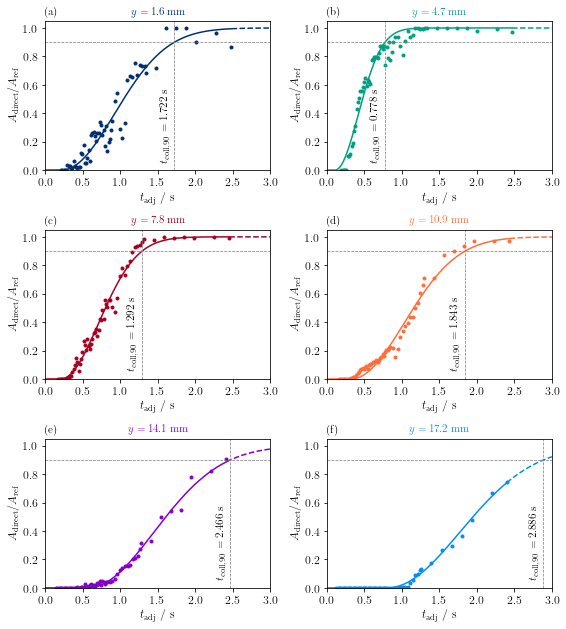

In [51]:
fig, axs = plt.subplots(nrows=3, ncols=2)

for i, (ax, rslt, ybc, part) in enumerate(
    zip(axs.flatten(), res[:6], yb_centers[:6], list('abcdef'))):
    arels = rel_areas[:, i]
    idx = ~np.isnan(arels)
    arels = arels[idx]
    tcrit = opt.brentq(lambda x: func(x, *rslt[0]) - racrit, 0, 5)
    ax.plot(t - tf[i], arels, '.', color=pltt[i])
    idx = tp <= np.max(t - tf[i])
    line, = ax.plot(tp[idx], func(tp[idx], *rslt[0]), color=pltt[i], ls='solid')
    line, = ax.plot(tp[~idx], func(tp[~idx], *rslt[0]), color=pltt[i], ls='dashed')
    clr = line.get_color()
    ax.axhline(y=racrit, ls='dashed', lw=.75, color='gray')
    ax.axvline(x=tcrit, ls='dashed', lw=.75, color='gray')
    ax.text(x=tcrit - .05, y=0.05, s=r'$t_\text{coll,90}=%.3f\,\mathrm{s}$' % tcrit,
            rotation=90, va='bottom', ha='right', color='k', fontsize=11)
    ax.set(
        xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$',
        ylabel=r'$A_\text{direct}/A_\text{ref}$',
        ylim=(0, 1.05), xlim=(0, 3)
    )
    ax.set_title(r'(%s)' % part, loc='left', fontsize=11)
    ax.set_title(r'$y=%.1f\,\text{mm}$' % ybc, fontsize=11, color=pltt[i])
fig.set(size_inches=(8, 9))
fig.subplots_adjust(top=.95, right=.98, bottom=.075, left=.1, hspace=.4, wspace=.25)

In [52]:
ythr = yb_centers[1:6]
ythr

array([ 4.6868085,  7.8113475, 10.9358865, 14.0604255, 17.1849645])

$$
 t_{\text{coll},90} = t_1 - \frac{\sqrt{\ln 10}}{a}
$$

In [53]:
tthr = np.asarray([r[0][1] + np.sqrt(np.log(10)) / r[0][0] for r in res[1:]])
tthr

array([0.77781151, 1.29212641, 1.84331523, 2.46557142, 2.88648466])

In [54]:
yb_centers

array([ 1.5622695,  4.6868085,  7.8113475, 10.9358865, 14.0604255,
       17.1849645, 20.3095035, 23.4340425, 26.5585815, 29.6831205])

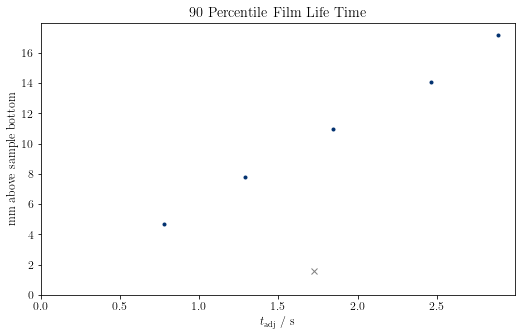

In [55]:
fig, ax = plt.subplots()

ax.plot(tthr, ythr, '.')
ax.plot(res[0][0][1] + np.sqrt(np.log(10)) / res[0][0][0], yb_centers[0],
        marker='x', color='gray')
ax.set(
    xlim=(0, None), ylim=(0, None),
    xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$', ylabel=r'mm above sample bottom',
    title=r'90 Percentile Film Life Time'
);

## Export to `asdf`

In [56]:
from pathlib import Path
import asdf

In [57]:
def export():
    p = Path('../data/run1_alldata.asdf')
    af = asdf.open(p, mode='rw') if p.exists() else asdf.AsdfFile(uri=p)
    if 'raw' not in af.keys():
        af['raw'] = {}
    afraw = af['raw']
    if 'polygons' not in afraw.keys():
        afraw['polygons'] = {}
    afpols = afraw['polygons']
    if 'polygons' not in afraw.keys():
        afraw['polygons'] = {}
    afpols = afraw['polygons']
    for frame in pols.frames:
        if frame not in afpols.keys():
            afpols[frame] = {}
        afpols[frame]['ref'] = pols[frame, 'ref'][0]
        try:
            afpols[frame]['film'] = pols[frame, 'film'][0]
        except KeyError:
            pass
        try:
            afpols[frame]['direct'] = pols[frame, 'direct']
        except KeyError:
            pass
    afraw['FRATE'] = FRATE
    afraw['IMRES'] = IMRES
    af['key_frames'] = {'FSTART': FSTART, 'FSUBM': FSUBM, 'FREF': FREF}
    af['key_frames']['desc'] = '' \
    '- `FSTART`: First contact of sample with water.' \
    '- `FREF`: Reference frame from which the sample outline was created.'
    af['frames_analyzed'] = pols.frames[MSTART:-1]
    af['time'] = {
        't': t,
        'tf': tf
    }
    if 'area' not in af.keys():
        af['area'] = {}
    ar = af['area']
    ar['yb_centers'] = yb_centers
    ar['fit'] = np.asarray([r[0] for r in res])
    ar['tthr'] = tthr
    ar['ythr'] = ythr
    af.info()
    af.write_to(af.uri, all_array_compression='zlib')
    af.close()

Run below cell (convert to code cell and run) to create the asdf data base.